In [1]:
jointMu = 0
jointSig = 0.001

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import readline
import GPy
from SAM.SAM_Core import SAMCore
from SAM.SAM_Core import SAMDriver
import pylab as pb
import sys 
from sys import executable
import subprocess
from subprocess import Popen, PIPE
import pickle
import os
from os import listdir, walk, system
from os.path import isfile, join, isdir
import time
import operator
import numpy
import numpy as np
import numpy.ma as ma
import datetime
import yarp
import copy
from itertools import combinations 
from ConfigParser import SafeConfigParser
from scipy.spatial import distance
from numpy.linalg import inv
import math
import ipyparallel as ipp
import random
from SAM.SAM_Core import staticPose

dataSetFolder = '/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset'
dataFolderList = ['lift-drop-right_arm', 
                  'lift-drop-left_arm', 
                  'push-pull-left_arm', 
                  'push-pull-right_arm']

dataFolders = []
labelFolders = []
#check folders in list actually exist
for j in dataFolderList:
    t = join(dataSetFolder,j,'data')
    m = join(dataSetFolder,j,'labels')
    if(isdir(t) and isdir(m)):
        dataFolders.append(t)
        labelFolders.append(m)
print '\n'.join(dataFolders)
print
print '\n'.join(labelFolders)
#subDirFolderList = ['camera/left', 'camera/right', 'data', 'kinect/rgb', 'labels']


/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-right_arm/data
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-left_arm/data
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-left_arm/data
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-right_arm/data

/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-right_arm/labels
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/lift-drop-left_arm/labels
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-left_arm/labels
/home/daniel/WYSIWYD_PROJECT/actionRecognitionDataset/push-pull-right_arm/labels


In [3]:
def distEuc(a,b):
    temp = a-b
    temp = np.square(temp)
    temp = np.sum(temp,1)
    return np.sqrt(temp)

def qtc_2D(k,l,q,thresh):
    
    d1 = distEuc(k[:-2],l[1:-1])
    d2 = distEuc(k[1:-1],l[1:-1])
    d3 = distEuc(k[2:],l[1:-1])
    
    for i in range(len(d1)):
        #threshold distance moved
        diff1 = d2[i]-d1[i]
        if(np.abs(diff1) < thresh):
            diff1 = 0

        diff2 = d3[i]-d2[i]
        if(np.abs(diff2) < thresh):
            diff2 = 0

        #convert to qtc
        if(diff1 > 0 and diff2 > 0):
            q[i] = -1
        elif(diff1 < 0 and diff2 < 0):
            q[i] = +1
        else:
            q[i] = 0
    
    return d2

def frenetFrame(arr):
    t_num = np.diff(arr,axis=0)
    t = (t_num/np.abs(t_num)).astype(int)

    b_num = np.cross(t[:-1],t[1:])
    b = b_num/np.abs(b_num)
    t = t[1:]

    n = np.cross(b,t)

    frameArr = np.concatenate((t,n,b),axis=1).T
    fArr = frameArr.reshape((3,3,-1),order = 'F')
    return fArr

def qtc_3D(k, l, thresh, q3, q4, q5):
    fFrameK = frenetFrame(k)
    fFrameL = frenetFrame(l)
    alpArr = np.zeros(q3.shape)
    betArr = np.zeros(q3.shape)
    gamArr = np.zeros(q3.shape)
    
    for g in range(fFrameK.shape[2]):
        fKinv = np.linalg.pinv(fFrameK[:,:,g])
        R = np.dot(fFrameL[:,:,g],fKinv)
        
        alpha = np.arctan(R[1,0]/R[0,0])
        den = np.sqrt(pow(R[2,1],2) + pow(R[2,2],2))
        
        beta = np.arctan(-R[2,0]/den)
        gamma = np.arctan(R[2,1]/R[2,2])

        #threshold angles
        if(np.abs(alpha) < thresh or math.isnan(alpha)):
            alpha = 0
        if(np.abs(beta) < thresh or math.isnan(beta)):
            beta = 0
        if(np.abs(gamma) < thresh or math.isnan(gamma)):
            gamma = 0
        alpArr[g] = alpha
        betArr[g] = beta
        gamArr[g] = gamma
        
        q3[g] = np.sign(alpha)
        q4[g] = np.sign(beta)
        q5[g] = np.sign(gamma)
    
    return [alpArr,betArr,gamArr]
            
def checkQTC(qtcArr):
    #array of shape x by 11 with 0 to 4 of 11 being the ones that unique must apply to
    tArr = copy.deepcopy(qtcArr)
    for i in range(1,tArr.shape[0]):
        if(i != 0):
            currRow = tArr[i,:]
            Mod = False
            for q in range(tArr.shape[1]):
                r = tArr[i,q] - tArr[i-1,q]
                if(r == -2 or r == 2):
                    Mod = True
                    currRow[q] = 0
            if(Mod):    
                qtcArr = np.insert(qtcArr,i,currRow,axis=0)    
                Mod = False
    return qtcArr

def uniqueQTC(currQTC):
    #array of shape x by 11 with 0 to 4 of 11 being the ones that unique must apply to
    i = 0
    del1 = False
    del2 = False
    
    while(i < currQTC.shape[0]-2):
        if(i!=0):
            if(np.array_equal(currQTC[i,:5],currQTC[i-1,:5])):
                del1 = True
            if(np.array_equal(currQTC[i+1,:5],currQTC[i-1,:5])):
                del2 = True
        
        if(del1 and not del2):
            currQTC = np.delete(currQTC,i,0)
        elif(del2):
            currQTC = np.delete(currQTC,i,0)
            currQTC = np.delete(currQTC,i+1,0)
            
        i+=1
    return currQTC

In [4]:
#load kinect skeleton data for all folders in dataFolderList
numJoints = 9
data = dict()
firstPass = True
jointsList = []
objectsList = []
labelsList = []
numFolders = len(dataFolders)

for j in dataFolders:
    k = dataFolders.index(j)
    dataFile = open(join(dataFolders[k],'data.log'),'r')
    labelFile = open(join(labelFolders[k],'data.log'),'r')
    
    #number of lines in dataFile
    for i, l in enumerate(dataFile):
            pass
    lenDataFile = i+1
    
    #number of lines in labelFile
    for i, l in enumerate(labelFile):
            pass
    lenLabelFile = i+1
    dataFile.close()
    labelFile.close()
    
    
    if(lenLabelFile != lenDataFile):
        raise ValueError('Files not of same lenght')
    else:
        dataFile = open(join(dataFolders[k],'data.log'),'r')
        labelFile = open(join(labelFolders[k],'data.log'),'r')
        labelsList.append([])
        
        for curr in range(lenDataFile):
            line = dataFile.readline()
            labelLine = labelFile.readline()
            
            t = line.replace('(','').replace(')','').split(' ')
            del t[0:4]
           
            v = labelLine.split(' ')[2].replace('\n','').replace('(','').replace(')','')
            if(v == ''):
                v = 'unknown'
            labelsList[k].append(v)
            
            #parse skeleton data which has 9 sections by (x,y,z)
            for i in range(numJoints):
                a = i*4
                if(t[a] == 'shoulderCenter'):
                    t[a] = 'chest'
                
                if(firstPass):
                    data[t[a]] = [None]*numFolders
                    data[t[a]][k] = (np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])]))
                    jointsList.append(t[a])
                else:
                    arr =  np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])])
                    if(data[t[a]][k] != None):
                        data[t[a]][k] = np.vstack((data[t[a]][k],arr))
                    else:
                        data[t[a]][k] = arr

            currIdx = (numJoints*4 -1)
            numObjs = (len(t) - currIdx)/5

            for i in range(numObjs):
                a = currIdx + 1 + (i*5)
                if(t[a] in data):
                    arr = np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])])
                    if(data[t[a]][k] != None):
                        data[t[a]][k] =  np.vstack((data[t[a]][k],arr))
                    else:
                        data[t[a]][k] = arr
                else:
                    data[t[a]] = [None]*(numFolders)
                    data[t[a]][k] = np.array([float(t[a+1]), float(t[a+2]), float(t[a+3])])
                    objectsList.append(t[a])

            firstPass = False
            
        dataFile.close()
        labelFile.close()

 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:59: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:71: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


In [5]:
print 'data has length = ' + str(len(data)) + ' joints'
strl =  'each joint has ' + str(len(data['head'])) + ' arrays of shape: '

for i in data['head']:
    strl += str(i.shape) + ', '
print strl

strl = 'labelsList has length = ' + str(len(labelsList)) + ' with sizes: '
for i in labelsList:
    strl += str(len(i)) + ', '
print strl

data has length = 12 joints
each joint has 4 arrays of shape: (4637, 3), (4907, 3), (5914, 3), (5440, 3), 
labelsList has length = 4 with sizes: 4637, 4907, 5914, 5440, 


In [6]:
#compile a list of all unique labels
setList = []
for x in labelsList:
    setList.append(list(set(x)))
flattenedList = [val for sublist in setList for val in sublist]
labels = list(set(flattenedList))
labels.sort()
for k in range(0,len(labels)):
    print str(k) + '  ' + labels[k]

0  agent_entry
1  agent_exit
2  arms_lowered
3  arms_raised
4  carry_object
5  drop_object
6  dropping_arms
7  lift_object
8  no_agent
9  pull_object
10  push_object
11  raising_arms
12  reach_object
13  retract_hand
14  unknown


In [7]:
dataStruct = []
verbose = True
for joint in jointsList+objectsList:
        for arr in range(len(data[joint])):
            for label in labels:
                if(verbose):
                    print
                    print 'current joint: ' + str(joint)
                    print 'curent label: ' + str(label)
                    print 'current dataset = ' + str(dataFolderList[arr])
                    print
                idxs = [i for i in range(len(labelsList[arr])) if labelsList[arr][i] == label]
                actionBlocks = []
                startIdx = 0
                for idxIndex in range(len(idxs)):
                    if(idxIndex != 0):
                        if(idxs[idxIndex] - idxs[idxIndex-1] != 1):
                            endIdx = idxIndex-1
                            actionData = data[joint][arr][startIdx:endIdx+1]
                            dataStruct.append([joint, label, arr, actionData.shape[0], actionData])
                            if(verbose):
                                print '[%s]' % ', '.join(map(str, dataStruct[-1][:-1]))
                            startIdx = idxIndex-1
                            #include end of previous acion as start of next action
                            #this is boundary idxIndex is start of next action and idxIndex-1 is end of previous action
                        if(idxIndex+2 > len(idxs)):
                            endIdx = idxIndex
                            actionData = data[joint][arr][startIdx:endIdx+1]
                            dataStruct.append([joint, label, arr, actionData.shape[0], actionData])
                            if(verbose):
                                print '[%s]' % ', '.join(map(str, dataStruct[-1][:-1]))
                            


current joint: elbowLeft
curent label: agent_entry
current dataset = lift-drop-right_arm

[elbowLeft, agent_entry, 0, 52]

current joint: elbowLeft
curent label: agent_exit
current dataset = lift-drop-right_arm

[elbowLeft, agent_exit, 0, 73]

current joint: elbowLeft
curent label: arms_lowered
current dataset = lift-drop-right_arm

[elbowLeft, arms_lowered, 0, 31]

current joint: elbowLeft
curent label: arms_raised
current dataset = lift-drop-right_arm

[elbowLeft, arms_raised, 0, 129]
[elbowLeft, arms_raised, 0, 57]

current joint: elbowLeft
curent label: carry_object
current dataset = lift-drop-right_arm

[elbowLeft, carry_object, 0, 43]
[elbowLeft, carry_object, 0, 31]
[elbowLeft, carry_object, 0, 46]
[elbowLeft, carry_object, 0, 41]
[elbowLeft, carry_object, 0, 32]
[elbowLeft, carry_object, 0, 28]
[elbowLeft, carry_object, 0, 35]
[elbowLeft, carry_object, 0, 39]
[elbowLeft, carry_object, 0, 74]
[elbowLeft, carry_object, 0, 40]
[elbowLeft, carry_object, 0, 34]
[elbowLeft, carry_ob

In [8]:
joint = 0
action = 1
dataset = 2
start = 3
end = 4
for a in range(len(dataFolderList)):
    print 'Dataset ' + str(a) + ' : ' + dataFolderList[a]
    for b in range(len(labels)):
        y = len([i[1] for i in dataStruct if i[joint] == 'head' and i[dataset] == a and i[action] == labels[b]])
        print '\t ' + str(labels[b]).ljust(15) + ' = ' + str(y).ljust(3) + ' repetitions'
    print



Dataset 0 : lift-drop-right_arm
	 agent_entry     = 1   repetitions
	 agent_exit      = 1   repetitions
	 arms_lowered    = 1   repetitions
	 arms_raised     = 2   repetitions
	 carry_object    = 20  repetitions
	 drop_object     = 20  repetitions
	 dropping_arms   = 4   repetitions
	 lift_object     = 20  repetitions
	 no_agent        = 2   repetitions
	 pull_object     = 1   repetitions
	 push_object     = 3   repetitions
	 raising_arms    = 4   repetitions
	 reach_object    = 24  repetitions
	 retract_hand    = 26  repetitions
	 unknown         = 24  repetitions

Dataset 1 : lift-drop-left_arm
	 agent_entry     = 1   repetitions
	 agent_exit      = 1   repetitions
	 arms_lowered    = 6   repetitions
	 arms_raised     = 5   repetitions
	 carry_object    = 17  repetitions
	 drop_object     = 17  repetitions
	 dropping_arms   = 5   repetitions
	 lift_object     = 17  repetitions
	 no_agent        = 2   repetitions
	 pull_object     = 0   repetitions
	 push_object     = 0   repetitions


In [9]:
jointsList.sort()
modJointsListHand_R = [i for i in jointsList if i != 'elbowRight' and i != 'handRight']
modJointsListHand_L = [i for i in jointsList if i != 'elbowLeft' and i != 'handLeft']

modJointsListHand_R = []
modJointsListHand_L = []
combinationList = []

if(len(modJointsListHand_R) > 0):
    for i in range(len(modJointsListHand_R)):
        combinationList.append(['handLeft', modJointsListHand_L[i]])
        combinationList.append(['handRight', modJointsListHand_R[i]])
    del combinationList[combinationList.index(['handLeft', 'handRight'])]

for i in objectsList[1:]:
    combinationList.append(['handLeft',i])
    combinationList.append(['handRight',i])


print 'Available joint pairs for hands:'
print
for i in combinationList:
    print '\t' + str(i)

Available joint pairs for hands:

	['handLeft', 'car']
	['handRight', 'car']
	['handLeft', 'octopus']
	['handRight', 'octopus']


In [10]:
humanStaticLabels = []
humanStaticLabels.append('left of')
humanStaticLabels.append('right of')
humanStaticLabels.append('on top of')
humanStaticLabels.append('underneath')
humanStaticLabels.append('in front of')
humanStaticLabels.append('behind')

In [11]:
#2 joint pairs will be used shoulder-hand and hand-object left and right doesnt matter
#both combine within a single model
#step 1 will be training these models with static poses to do clustering with a full GP configuration
joint = 0
action = 1
dataset = 2
start = 3
end = 4
verbose = True

contactThreshold = 0.1
deltaDistanceThreshold = 0.000005
originThreshold = 0.01
angleThreshold = 0.001

firstPass = True
handDataStruct = []

for currComb in combinationList:
    print str(currComb[0]) +'-' +str(currComb[1])
    infoK = [i for i in dataStruct if i[joint] == currComb[0]]
    infoL = [i for i in dataStruct if i[joint] == currComb[1]]
    
    for i in range(len(infoK)):
        Pk = infoK[i][4]
        Pl = infoL[i][4]
        
        #add gaussian noise on output
        Pk_Noise = np.random.normal(jointMu, jointSig, Pk.shape)
        Pl_Noise = np.random.normal(jointMu, jointSig, Pl.shape)
        
        Pk = Pk + Pk_Noise
        Pl = Pl + Pl_Noise
        
        q1 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #motion of k relative to l
        q2 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #motion of l relative to k
        q3 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #alpha
        q4 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #beta
        q5 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #gamma
        q7 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #contact
        q8 = np.zeros((Pk.shape[0]-2,1), dtype=np.int) #human static label

        lowV = np.abs(Pk) < originThreshold  # Where values are low
        Pk[lowV] = 0
        
        lowV = np.abs(Pl) < originThreshold  # Where values are low
        Pl[lowV] = 0
        
        q6 = Pl[1:-1]-Pk[1:-1] #direction vector from joint to joint

        q9 = qtc_2D(Pk,Pl,q1, deltaDistanceThreshold)
        lowV = np.abs(q9) < contactThreshold
        q7[lowV] = 1
        
        qtc_2D(Pl,Pk,q2, deltaDistanceThreshold)
        [a,b,g] = qtc_3D(Pk, Pl, angleThreshold, q3, q4, q5)
        
        for h in range(q6.shape[0]):
            #x at 0 is depth with negative meaning behind an object
            #y at 1 is width with negative meaning partner-right = ego-left
            #x at 2 is height with negative meaning underneath
            currVec = np.abs(q6[h,:])
            maxIDx = currVec.argmax()
            if(maxIDx == 0):
                if(np.sign(q6[h,maxIDx]) == -1):
                    #behind
                    q8[h] = humanStaticLabels.index('behind')
                elif(np.sign(q6[h,maxIDx]) == 1):
                    #in front
                    q8[h] = humanStaticLabels.index('in front of')
            elif(maxIDx == 1):
                if(np.sign(q6[h,maxIDx]) == -1):
                    #left
                    q8[h] = humanStaticLabels.index('left of')
                elif(np.sign(q6[h,maxIDx]) == 1):
                    #right
                    q8[h] = humanStaticLabels.index('right of')
            elif(maxIDx == 2):
                if(np.sign(q6[h,maxIDx]) == -1):
                    #underneath
                    q8[h] = humanStaticLabels.index('underneath')
                elif(np.sign(q6[h,maxIDx]) == 1):
                    #top of
                    q8[h] = humanStaticLabels.index('on top of')  
        
        
        tempQTC = np.hstack((q1,q2,q3,q4,q5,q6[:,0,None],q6[:,1,None],q6[:,2,None],q7,q8,q9[:,None]))
        
        #q1,q2 -> relative movement of points in terms of distance from each other (closer / farther)
        #q3-5-> relative movement of joints in tems of orientation from each other (difference in the paths they are following wrt each other)
        #q6_1 to _3 -> direction vector from hand to other joint
        #q7 -> contact status
        #q8 -> humanStaticLabel
        
        g = tempQTC.shape[0]
        tempQTC2 = uniqueQTC(tempQTC)

        gg = tempQTC2.shape[0]
        
        tempQTC = checkQTC(tempQTC2)
        
        ggg = tempQTC.shape[0]

        handDataStruct.append([currComb[0], currComb[1], infoK[i][1], infoK[i][2], tempQTC.shape[0], tempQTC])
        
        if(verbose):
            print '[%s]' % ', '.join(map(str, handDataStruct[-1][:-1]))
            print str((ggg-gg)).ljust(3) + ' added in check QTC'
            print str((gg-g)).ljust(3) + ' added in unique QTC'
            print
        

handLeft-car
[handLeft, car, agent_entry, 0, 81]
31  added in check QTC
0   added in unique QTC

[handLeft, car, agent_exit, 0, 62]
25  added in check QTC
-34 added in unique QTC

[handLeft, car, arms_lowered, 0, 46]
17  added in check QTC
0   added in unique QTC

[handLeft, car, arms_raised, 0, 75]
30  added in check QTC
-82 added in unique QTC

[handLeft, car, arms_raised, 0, 58]
20  added in check QTC
-17 added in unique QTC

[handLeft, car, carry_object, 0, 61]
25  added in check QTC
-5  added in unique QTC

[handLeft, car, carry_object, 0, 27]
11  added in check QTC
-13 added in unique QTC

[handLeft, car, carry_object, 0, 44]
16  added in check QTC
-16 added in unique QTC

[handLeft, car, carry_object, 0, 59]
20  added in check QTC
0   added in unique QTC

[handLeft, car, carry_object, 0, 28]
8   added in check QTC
-10 added in unique QTC

[handLeft, car, carry_object, 0, 40]
14  added in check QTC
0   added in unique QTC

[handLeft, car, carry_object, 0, 32]
11  added in check Q

 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning:divide by zero encountered in divide
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning:divide by zero encountered in double_scalars
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: RuntimeWarning:invalid value encountered in divide
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning:invalid value encountered in double_scalars
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning:invalid value encountered in double_scalars
 /home/daniel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning:invalid value encountered in double_scalars


[handLeft, car, drop_object, 0, 12]
4   added in check QTC
-12 added in unique QTC

[handLeft, car, drop_object, 0, 33]
14  added in check QTC
0   added in unique QTC

[handLeft, car, drop_object, 0, 34]
13  added in check QTC
-7  added in unique QTC

[handLeft, car, drop_object, 0, 32]
11  added in check QTC
-7  added in unique QTC

[handLeft, car, drop_object, 0, 26]
9   added in check QTC
0   added in unique QTC

[handLeft, car, drop_object, 0, 18]
7   added in check QTC
-16 added in unique QTC

[handLeft, car, drop_object, 0, 42]
16  added in check QTC
-6  added in unique QTC

[handLeft, car, drop_object, 0, 22]
7   added in check QTC
0   added in unique QTC

[handLeft, car, drop_object, 0, 23]
10  added in check QTC
0   added in unique QTC

[handLeft, car, drop_object, 0, 11]
1   added in check QTC
-6  added in unique QTC

[handLeft, car, drop_object, 0, 33]
12  added in check QTC
0   added in unique QTC

[handLeft, car, drop_object, 0, 29]
11  added in check QTC
0   added in uniq

In [12]:
#here model trains recognition of object location wrt each other
#feature vector => handDataStruct[5][:,5:8](vector from hand to object) and humanlabel handDataStruct[5][:,9]
for a in range(len(handDataStruct)):
    if(a == 0):
        staticPoseY = handDataStruct[a][5][:,5:8]
        staticPoseL = handDataStruct[a][5][:,9,None]
    else:
        staticPoseY = np.vstack((staticPoseY, handDataStruct[a][5][:,5:8]))
        staticPoseL = np.vstack((staticPoseL, handDataStruct[a][5][:,9,None]))
        
print staticPoseY.shape
print staticPoseL.shape


(87874, 3)
(87874, 1)


In [32]:
staticPoseModel = staticPose.staticPose()
staticPoseModel.readData(0,0,staticPoseY,staticPoseL, humanStaticLabels)

staticPoseModel.Quser = 2
Ntr = int(len(staticPoseModel.L)*70/100)
model_type = 'mrd'
model_num_inducing = 6
model_num_iterations = 300 #100
model_init_iterations = 300 #300
save_model=True
economy_save = True
visualise_output=True
experiment_number = 1
fname = '/home/daniel/SAM_Data_Models/Models/staticPose_exp' + str(experiment_number)

[Yall,Lall,YtestAll,LtestAll] = staticPoseModel.prepareData (model_type, Ntr,randSeed=experiment_number)


In [33]:
staticPoseModel.training(model_num_inducing, model_num_iterations, model_init_iterations, fname, save_model, economy_save, keepIfPresent=True)


Try loading economy size SAMObject: /home/daniel/SAM_Data_Models/Models/staticPose_exp1
Loading /home/daniel/SAM_Data_Models/Models/staticPose_exp1 failed.
Parameters not valid. Training new model
Saving SAMObject: /home/daniel/SAM_Data_Models/Models/staticPose_exp1


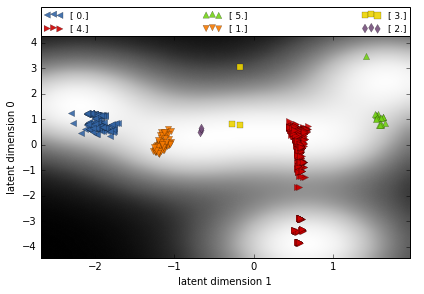

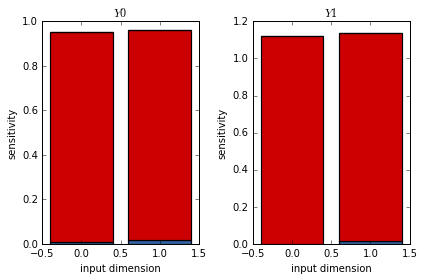

In [34]:
if visualise_output: 
    ax = staticPoseModel.SAMObject.visualise()
    visualiseInfo=dict()
    visualiseInfo['ax']=ax
else:
    visualiseInfo=None

In [35]:
# curTestData = Yall[][None,:].tolist()
def formatDataFunc(Ydata):
        yDataList = []
        for j in range(Ydata.shape[0]):
            yDataList.append(Ydata[j][None,:])
        return yDataList

def testFunc(data, lab):
    d = staticPoseModel.testing(data, False)
    if(lab == d[0]):
        result = True
    else:
        result = False
    print 'Actual  ' + str(lab).ljust(11) + '  Model:  ' + str(d[0]).ljust(11) + '  with ' + str(d[1])[:6] + ' confidence: ' + str(result) + '\n'
    return d

In [36]:
def plot_confusion_matrix(cm, targetNames, title='Confusion matrix', cmap=plt.cm.inferno):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(targetNames))
    plt.xticks(tick_marks, targetNames, rotation=45)
    plt.yticks(tick_marks, targetNames)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=1, truncate=1000):
    while not ar.ready():
        stdouts = ar.stdout
        if any(stdouts):
            clear_output()
            print '-' * 30
            print "%.3fs elapsed" % ar.elapsed
            print ""
            for stdout in ar.stdout:
                if stdout:
                    print "\n%s" % (stdout[-truncate:])
            sys.stdout.flush()
        time.sleep(dt)

In [ ]:
c = ipp.Client()
dview = c[:]

with dview.sync_imports():
    from SAM.SAM_Core import staticPose

dview.push({'staticPoseModel':staticPoseModel})

importing staticPose from SAM.SAM_Core on engine(s)


<AsyncResult: _push>

In [ ]:
ss = []
sstest = []
print
off1 = 11
off2 = 8

# allCount = Yall.shape[0]
# factor = 40
# numItems = int(allCount/factor)
cmSize = len(staticPoseModel.textLabels)
confMatrix = np.zeros((cmSize, cmSize))
numItems = 200

off3 = len(str(numItems))

print 'estimated time: ' + str(numItems/60) + 'mins for ' + str(numItems) + ' items'
#format training data

yTrainingData = formatDataFunc(Yall)
YsampleIdx = [ i for i in sorted(random.sample(xrange(len(yTrainingData)),numItems)) ]

Ysample = [yTrainingData[i] for i in YsampleIdx]
Lsample = [staticPoseModel.textLabels[int(Lall[i])] for i in YsampleIdx]
    
%time syn = dview.map_async(testFunc, Ysample, Lsample)
wait_watching_stdout(syn, dt=1, truncate=1000)
ret = syn.get()
clear_output()
for i in range(len(ret)):

    currLabel = Lsample[i]

    if(currLabel == ret[i][0]):
        result = True
    else:
        result = False
    print str(i).rjust(off3) + '/' + str(numItems) + ' Truth: ' + currLabel.ljust(off1) + ' Model: ' + ret[i][0].ljust(off1) + ' with ' + str(ret[i][1])[:6].ljust(off2) + ' confidence: ' + str(result)
    confMatrix[staticPoseModel.textLabels.index(currLabel),staticPoseModel.textLabels.index(ret[i][0])] += 1
    
plot_confusion_matrix(confMatrix, staticPoseModel.textLabels)

------------------------------
64.195s elapsed


Actual  left of      Model:  in front of  with 0.3391 confidence: False

Actual  left of      Model:  in front of  with 0.5765 confidence: False

Actual  left of      Model:  in front of  with 0.3375 confidence: False

Actual  in front of  Model:  in front of  with 0.4777 confidence: True

Actual  in front of  Model:  in front of  with 0.2188 confidence: True

Actual  left of      Model:  in front of  with 0.3419 confidence: False

Actual  left of      Model:  in front of  with 0.3407 confidence: False

Actual  left of      Model:  in front of  with 0.3434 confidence: False

Actual  left of      Model:  in front of  with 0.3381 confidence: False

Actual  in front of  Model:  in front of  with 0.5674 confidence: True

Actual  in front of  Model:  in front of  with 0.6238 confidence: True



Actual  left of      Model:  in front of  with 0.2688 confidence: False

Actual  in front of  Model:  in front of  with 0.4621 confidence: True

Actua

In [ ]:
from sklearn.preprocessing import normalize
w_normalized = confMatrix / confMatrix.sum(axis=1)
print w_normalized

percCorect = np.diag(confMatrix).sum()/numItems
print confMatrix
normConf = confMatrix / confMatrix.astype(np.float).sum(axis=1)

print
print 'Nomalised Confusion Matrix = '
print normConf
print 

print str(percCorect) + " %% correct for training data"

for i in range(cmSize):
    for j in range(cmSize):
        print str(normConf[i,j]*100) + '%% of ' + str(staticPoseModel.textLabels[i]) + ' classified as' + str(staticPoseModel.textLabels[j])
    print

print

In [ ]:
# #format training data
# yTestingData = formatDataFunc(Ytest)
# # allCount = Ytest.shape[0]
# prin allCount
# %time ret = dview.map_sync(testFunc, yTestingData[:allCount])

# for i in range(len(ret)):

#     currLabel = staticPoseModel.textLabels[int(Ltest[i])]

#     if(currLabel == ret[i][0]):
#         result = True
#     else:
#         result = False
#     print str(i).rjust(off3) + '/' + str(allCount) + ' Truth: ' + currLabel.ljust(off1) + ' Model: ' + ret[i][0].ljust(off1) + ' with ' + str(ret[i][1])[:6].ljust(off2) + ' confidence: ' + str(result)
#     ss.append(result)

# correctVal = sum(ss)
# percCorect = correctVal*100/allCount
# print str(percCorect) + " percent correct for training data"
# print '\n\n\n'

In [ ]:
np.diag(confMatrix).sum()